In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Bidirectional, AveragePooling1D, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D, CuDNNGRU , GlobalAveragePooling1D, Concatenate, TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Menampilkan informasi perangkat GPU yang digunakan
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    device_details = tf.config.experimental.get_device_details(device)
    print(device_details)
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

try:
    print(f'Found {physical_devices[0]} GPU(s)')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0])
    print('Memory growth set to True, using Nvidia Tesla T4')
except:
    print('Failed to set memory growth to True')
    pass

{'compute_capability': (7, 0), 'device_name': 'Tesla V100-SXM2-16GB'}
Found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') GPU(s)
Memory growth set to True, using Nvidia Tesla T4


## BIGU-CNN_TFIDF_UNIGRAM_BIGRAM_TRIGRAM_DROPOUT0.5
Copyright @I Gde Bagus Janardana Abasan

In [3]:
def process_data():
  dataset = pd.read_csv('../../../data/data_preprocessed/hasil_ekspansi/twitter/DatasetHatespeech_UnigramBigramTrigram_Top1_ExpandedTwitter.csv')
  # make data['label_fase_1'] to 0 and 1 binary classifier karena tensor hanya bisa input 0 =< label =< 1
  dataset['label final'] = dataset['label final'].apply(lambda x: 1 if x == 'HS' else 0)

  # to_pd
  y_final = dataset['label final']
  x_final = dataset.drop('label final', axis=1)

  # split
  print("proses splitting....")
  X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=0)
  print("done splitting")
  
  return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = process_data()

proses splitting....
done splitting


In [5]:
def create_bigru_cnn_model(X_train, y_train, X_test, y_test, units):
  # reshape# reshape train and test data
  X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
  X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

  model = Sequential()
  model.add(Bidirectional(GRU(units, input_shape=(X_train.shape), activation='relu', return_sequences=True)))
  model.add(Conv1D(filters=units, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
  model.add(Flatten())
  model.add(Dense(units = 32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 1, activation='sigmoid'))
  opt = Adam(learning_rate=0.00005)
  model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['accuracy'])
  input_shape = X_train.shape
  model.build(input_shape)
  model.summary()
  print()
  model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data = (X_test, y_test))
  loss = model.history.history['loss']
  val_loss = model.history.history['val_loss']
  score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
  print()
  print('Validation Accuracy:', score[1])
  print('Validation Loss:', score[0])
  print()

  return model, loss, val_loss

In [6]:
def call(X_train, X_test, y_train, y_test):
  model, loss, val_loss = create_bigru_cnn_model(X_train, y_train, X_test, y_test, 32)
   # predict
  X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])
  y_pred = model.predict(X_test)

  # confusion matrix
  classreport = classification_report(y_test, y_pred.round(), digits=4)
  print()
  print(classreport)
  print()
  accscore = accuracy_score(y_test, y_pred.round())
  precscore = precision_score(y_test, y_pred.round(), zero_division=0)
  recscore = recall_score(y_test, y_pred.round())
  f1score = f1_score(y_test, y_pred.round(), average='weighted', zero_division=0)

  return [accscore, precscore, recscore, f1score, loss, val_loss]

In [7]:
result = []
for i in range (5):
  result.append([i+1] + call(X_train, X_test, y_train, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (44856, 1, 64)           1926528   
 l)                                                              
                                                                 
 conv1d (Conv1D)             (44856, 1, 32)            6176      
                                                                 
 max_pooling1d (MaxPooling1D  (44856, 1, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (44856, 32)               0         
                                                                 
 dense (Dense)               (44856, 32)               1056      
                                                                 
 dropout (Dropout)           (44856, 32)               0

In [8]:
def loss_func(df):
  for idx, val in enumerate(df['No']):
    plt.plot(df['Loss'].iloc[idx])
    plt.plot(df['Val Loss'].iloc[idx])
    plt.title(f'loss function BiGRU+CNN UNIGRAM_BIGRAM_TRIGRAM_DROPOUT0.5-{idx+1}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.savefig(f'hasil/grafik/lossfunctionGraphics_BIGRU_CNN_UNIGRAM_BIGRAM_TRIGRAM_DROPOUT0.5_FE_TWITTER_TOP1-{idx+1}.png')
    plt.show()
    plt.clf()

Average Accuracy : 0.8727382146439318
Average Precision : 0.8754844236488639
Average Recall : 0.893519882179676
Average F1 Score : 0.8725908047686527


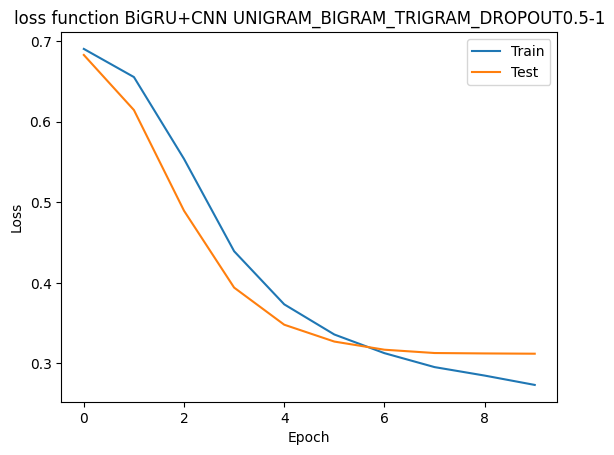

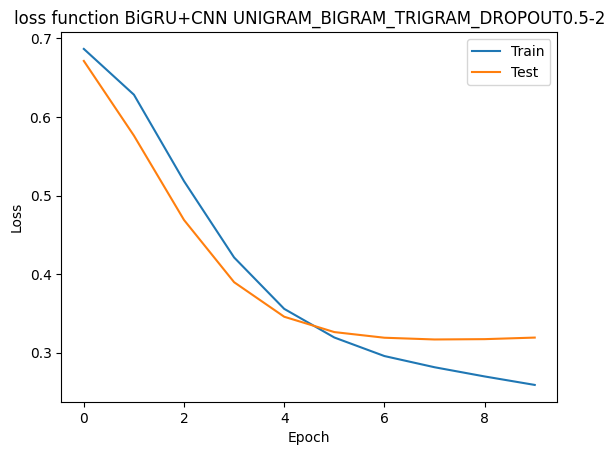

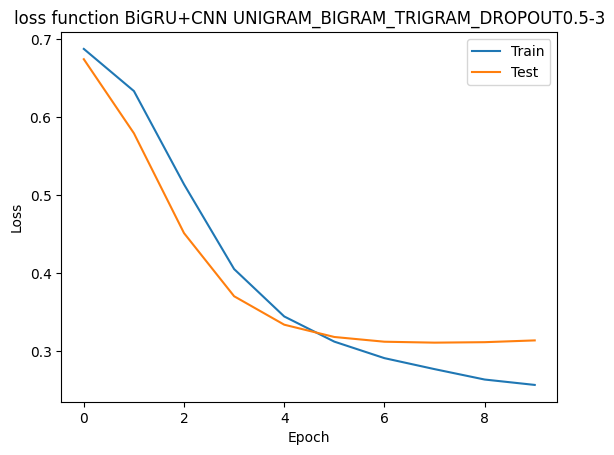

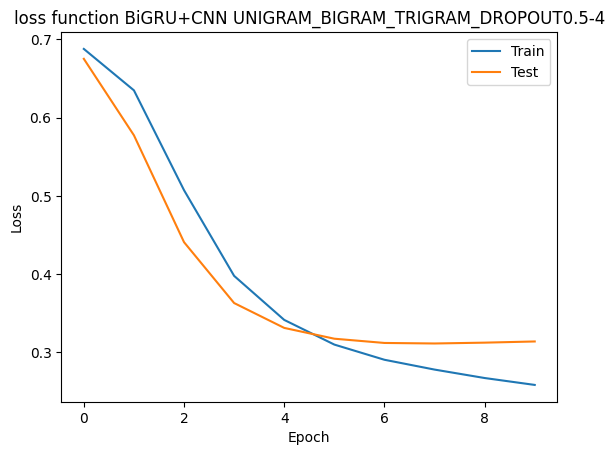

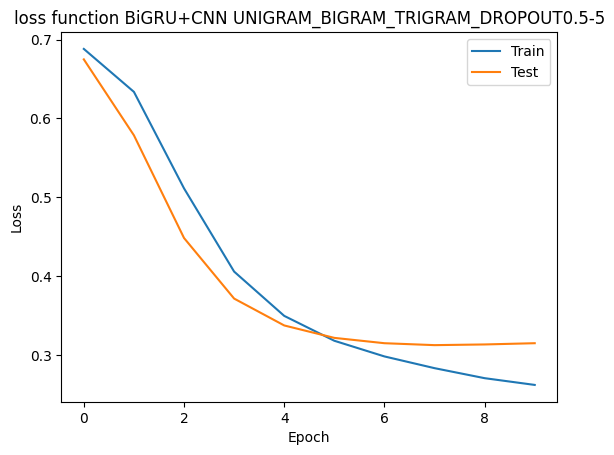

<Figure size 640x480 with 0 Axes>

In [9]:
df = pd.DataFrame(result, columns=['No', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Loss', 'Val Loss'])
df.to_csv('hasil/hasil_BIGRU_CNN_UNIGRAM_BIGRAM_TRIGRAM_DROPOUT0.5_FE_TWITTER_TOP1.csv', index=False)

#average
print('Average Accuracy :', df['Accuracy'].mean())
print('Average Precision :', df['Precision'].mean())
print('Average Recall :', df['Recall'].mean())
print('Average F1 Score :', df['F1 Score'].mean())
loss_func(df)